# Emotion Classification
This notebook covers two main methods of classification:
1. A custom Ensemble Method using a Random Forest Classifier for video features and Support Vector Classifier for audio features.
2. Using a Multilayer Perceptron for classification.

The objective of this project is not to create the most effective model--high accuracy could easily be achieved with a deeper model--but, it is to instead show the efficacy of building a robust feature extraction pipeline for machine learning tasks.

### Importing Libraries and Data

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from tensorly.tenalg import multi_mode_dot
from tensorly.decomposition import partial_tucker
from tqdm.notebook import tqdm

In [2]:
train_test_data_dir = os.path.join(os.getcwd(), 'Train_Test_Data')
hog3d_data_dir = os.path.join(os.getcwd(), 'HOG3d_Data')
audio_data_dir = os.path.join(os.getcwd(), 'Audio_Data')

y_train = np.load(os.path.join(train_test_data_dir, 'y_train.npy')) - 1
y_test = np.load(os.path.join(train_test_data_dir, 'y_test.npy')) - 1

id_train = np.load(os.path.join(train_test_data_dir, 'id_train.npy'))
id_test = np.load(os.path.join(train_test_data_dir, 'id_test.npy'))

video_train = np.load(os.path.join(hog3d_data_dir, 'H_train.npy')) # HOG 3D Data
video_test = np.load(os.path.join(hog3d_data_dir, 'H_test.npy'))

video_train_mean = video_train.mean()
video_train_std = video_train.std()
video_train = (video_train - video_train_mean) / video_train_std
video_test = (video_test - video_train_mean) / video_train_std

audio_train = np.load(os.path.join(audio_data_dir, 'Audio_train.npy')) # B-Spline Audio Data
audio_test = np.load(os.path.join(audio_data_dir, 'Audio_test.npy'))

audio_train_mean = audio_train.mean()
audio_train_std = audio_train.std()
audio_train = (audio_train - audio_train_mean) / audio_train_std
audio_test = (audio_test - audio_train_mean) / audio_train_std

print(video_train.shape)
print(video_test.shape)
print(audio_train.shape)
print(audio_test.shape)

labels = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
labels_dict = {i: label for i, label in enumerate(labels)}

(960, 48, 71, 10, 9, 2)
(480, 48, 71, 10, 9, 2)
(960, 14, 272)
(480, 14, 272)


### Additional Dimensionality Reduction

The data is still quite large at this point, especially the 3D Histogram of Gradients. Since our data is stored as a high-dimensional tensor, we can apply Partial Tucker Decomposition, or Higher-Order Singular Value Decomposition, to reduce specific dimensions, without affecting the structure of other dimensions. Here's a brief overview of how Tucker Decomposition works:
Given a tensor $\mathcal{X} \in \mathbb{R}^{I_1 \times I_2 \times \cdots \times I_N}$, Tucker decomposition approximates $\mathcal{X}$ as [1]:

$$
\mathcal{X} \approx \mathcal{G} \times_1 A^{(1)} \times_2 A^{(2)} \times_3 \cdots \times_N A^{(N)}
$$

where:
- $\mathcal{G} \in \mathbb{R}^{J_1 \times J_2 \times \cdots \times J_N}$ is the core tensor.
- $A^{(n)} \in \mathbb{R}^{I_n \times J_n}$ are the factor matrices for each mode $n$.

The operator $\times_n$ denotes the mode-$n$ product between a tensor and a matrix. Specifically, the mode-$n$ product of a tensor $\mathcal{G}$ with a matrix $A$ is defined as:

$$
(\mathcal{G} \times_n A)_{i_1 i_2 \cdots i_{n-1} j i_{n+1} \cdots i_N} = \sum_{i_n} \mathcal{G}_{i_1 i_2 \cdots i_N} A_{j i_n}
$$

![Tucker Decomposition](https://www.researchgate.net/publication/257482079/figure/fig1/AS:651178434121728@1532264445031/Third-order-Tucker-decomposition.png)

Source: https://www.researchgate.net/figure/Third-order-Tucker-decomposition_fig1_257482079

In [3]:
ranks = [8, 8, 3, 1]
modes = [1, 2, 3, 5]

data, _ = partial_tucker(video_train, ranks, modes=modes, verbose=True, tol=1e-4)

V_train = data[0]
train_factors = data[1]

del data
gc.collect()

V_test = multi_mode_dot(video_test, [U.T for U in train_factors], modes=modes)

V_train = V_train.reshape(V_train.shape[0], -1)
V_test = V_test.reshape(V_test.shape[0], -1)

print(V_train.shape)
print(V_test.shape)

reconstruction error=0.7413391053727788, variation=4.772330974067707e-06.
converged in 2 iterations.
(960, 1728)
(480, 1728)


In [4]:
ranks = [10, 150]
modes = [1, 2]

data, _ = partial_tucker(audio_train, ranks, modes=modes, verbose=True, tol=1e-4)

A_train = data[0]
train_factors = data[1]

del data
gc.collect()

A_test = multi_mode_dot(audio_test, [U.T for U in train_factors], modes=modes)

A_train = A_train.reshape(A_train.shape[0], -1)
A_test = A_test.reshape(A_test.shape[0], -1)

print(A_train.shape)
print(A_test.shape)

reconstruction error=0.038799555081921955, variation=0.0.
converged in 2 iterations.
(960, 1500)
(480, 1500)


### Developing Non-Neural Network Models for Classification

In [5]:
def visualize_results(X_test, y_test, model, labels):
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model accuracy: \033[1m{accuracy}\033[0m')

    conf_matrix = confusion_matrix(y_test, y_pred)

    clf_report = classification_report(y_test, y_pred, output_dict=True)
    clf_df = pd.DataFrame(clf_report).transpose()

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', ax=axes[0],
            xticklabels=labels, yticklabels=labels)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(clf_df.iloc[:-1, :-1], annot=True, cmap='icefire', fmt='.2f', ax=axes[1], yticklabels=labels)
    axes[1].set_title('Classification Report')

    plt.show()

    return clf_df.T

#### Here's the performance of the reduced video data using sklearn's RandomForestClassifier class:

Performance of Video Data Alone:
Model accuracy: 0.6854166666666667


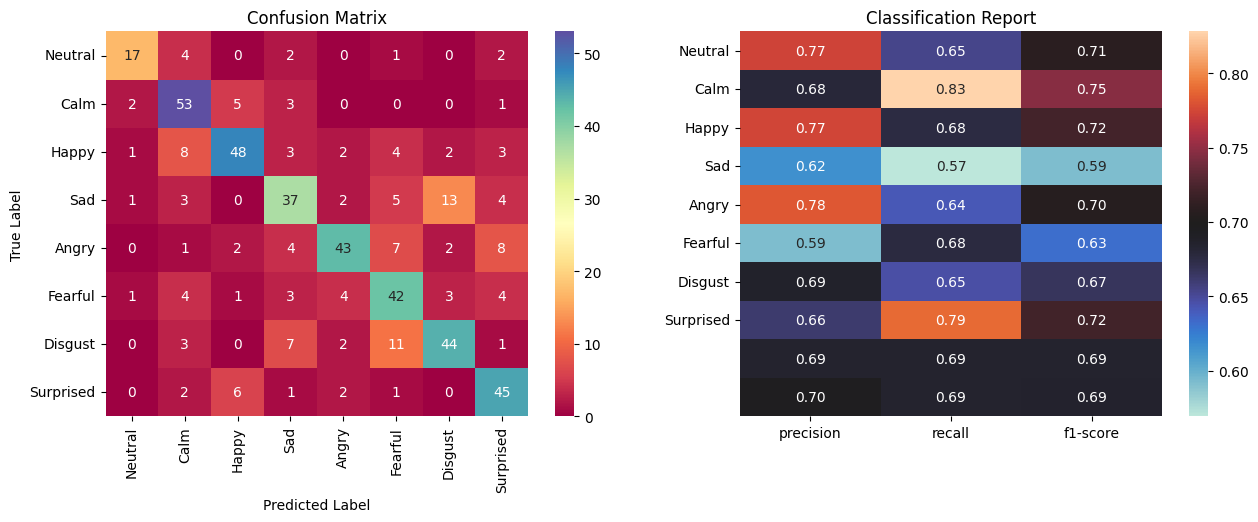

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.772727,0.679487,0.774194,0.616667,0.781818,0.591549,0.687500,0.661765,0.685417,0.695713,0.691995
recall,0.653846,0.828125,0.676056,0.569231,0.641791,0.677419,0.647059,0.789474,0.685417,0.685375,0.685417
f1-score,0.708333,0.746479,0.721805,0.592000,0.704918,0.631579,0.666667,0.720000,0.685417,0.686473,0.684750
support,26.000000,64.000000,71.000000,65.000000,67.000000,62.000000,68.000000,57.000000,0.685417,480.000000,480.000000


In [6]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(V_train, y_train)

print('Performance of Video Data Alone:')
visualize_results(V_test, y_test, rfc, labels)

#### Here's the performance of the reduced audio data using sklearn's SVC class:

Performance of Audio Data Alone:
Model accuracy: 0.6854166666666667


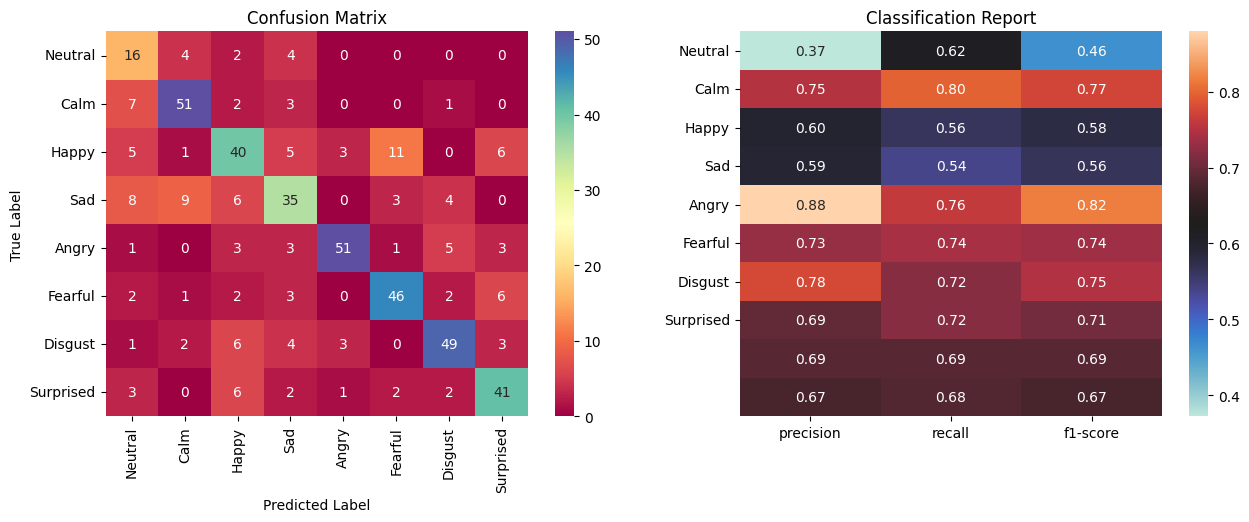

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.372093,0.750000,0.597015,0.593220,0.879310,0.730159,0.777778,0.694915,0.685417,0.674311,0.698551
recall,0.615385,0.796875,0.563380,0.538462,0.761194,0.741935,0.720588,0.719298,0.685417,0.682140,0.685417
f1-score,0.463768,0.772727,0.579710,0.564516,0.816000,0.736000,0.748092,0.706897,0.685417,0.673464,0.689235
support,26.000000,64.000000,71.000000,65.000000,67.000000,62.000000,68.000000,57.000000,0.685417,480.000000,480.000000


In [7]:
svc = SVC(kernel='poly', C=0.95, gamma=1e-2, probability=True)
svc.fit(A_train, y_train)

print('Performance of Audio Data Alone:')
visualize_results(A_test, y_test, svc, labels)

#### Now, I combine the stengths of both of these models using the following approach:

1. Initialize a k-fold cross validation loop, train the models, and output a prediction set of class probabilities on the test data.
2. Run an optimization algorithm to find the optimal weights that minimizes the absolute difference in number of labels per class.
3. Repeat this across every fold, collecting the weights for the video and audio models.
4. Average the weights at the end of the cross validation loop, and apply them to the full testing dataset.

In [8]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

video_weights = np.zeros((k, np.unique(y_train).shape[0]))
audio_weights = np.zeros((k, np.unique(y_train).shape[0]))

fold = 1
for train_index, val_index in tqdm(kf.split(V_train), total=kf.get_n_splits(), desc="K-Fold Cross-Validation"):
    V_tr, V_val = V_train[train_index], V_train[val_index]
    A_tr, A_val = A_train[train_index], A_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
    rfc.fit(V_tr, y_tr)
    prob_video_val = rfc.predict_proba(V_val)

    svc = SVC(kernel='poly', C=0.95, gamma=1e-2, probability=True)
    svc.fit(A_tr, y_tr)
    prob_audio_val = svc.predict_proba(A_val)

    num_classes = prob_video_val.shape[1]
    best_accuracy = 0
    best_video_weights = np.ones(num_classes) / 2
    best_audio_weights = np.ones(num_classes) / 2

    for c in tqdm(range(num_classes)):
        class_indices = np.where(y_val == c)[0]
        if len(class_indices) == 0:
            best_video_weights[c] = 0.5
            best_audio_weights[c] = 0.5
            continue

        best_class_error = float('inf')
        for w1 in np.arange(0, 1.01, 0.01):
            w2 = 1 - w1
            combined_probs = np.copy(prob_video_val)
            combined_probs[:, c] = (w1 * prob_video_val[:, c] + w2 * prob_audio_val[:, c])
            y_pred = np.argmax(combined_probs, axis=1)
            class_error = abs((y_pred == c).sum() - len(class_indices))

            if class_error < best_class_error:
                best_class_error = class_error
                best_video_weights[c] = w1
                best_audio_weights[c] = w2

    video_weights[fold-1, :] += best_video_weights
    audio_weights[fold-1, :] += best_audio_weights

    combined_probs_val = (best_video_weights * prob_video_val + best_audio_weights * prob_audio_val)
    y_pred_val = np.argmax(combined_probs_val, axis=1)
    fold_accuracy = accuracy_score(y_val, y_pred_val)
    print(f'Fold {fold} Accuracy: {fold_accuracy:.4f}')

    fold += 1

average_video_weights = np.mean(video_weights, axis=0)
average_audio_weights = np.mean(audio_weights, axis=0)

K-Fold Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Fold 1 Accuracy: 0.7344


  0%|          | 0/8 [00:00<?, ?it/s]

Fold 2 Accuracy: 0.7135


  0%|          | 0/8 [00:00<?, ?it/s]

Fold 3 Accuracy: 0.6719


  0%|          | 0/8 [00:00<?, ?it/s]

Fold 4 Accuracy: 0.6406


  0%|          | 0/8 [00:00<?, ?it/s]

Fold 5 Accuracy: 0.7760


Performance of Ensemble Model:
Model accuracy: 0.7770833333333333


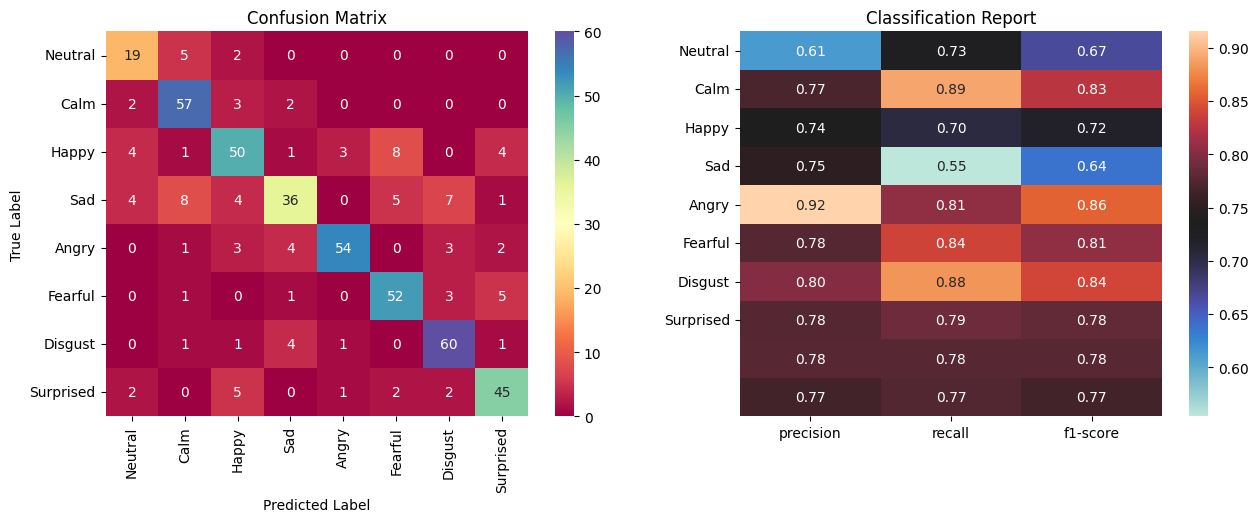

In [9]:
rfc_final = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc_final.fit(V_train, y_train)

svc_final = SVC(kernel='poly', C=0.95, gamma=1e-2, probability=True)
svc_final.fit(A_train, y_train)

prob_video = rfc_final.predict_proba(V_test)
prob_audio = svc_final.predict_proba(A_test)
combined_probs = (average_video_weights * prob_video + average_audio_weights * prob_audio)
final_preds = np.argmax(combined_probs, axis=1)

print('Performance of Ensemble Model:')
accuracy = accuracy_score(y_test, final_preds)
print(f'Model accuracy: \033[1m{accuracy}\033[0m')
conf_matrix = confusion_matrix(y_test, final_preds)
clf_report = classification_report(y_test, final_preds, output_dict=True)
clf_df = pd.DataFrame(clf_report).transpose()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', ax=axes[0],
            xticklabels=labels, yticklabels=labels)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(clf_df.iloc[:-1, :-1], annot=True, cmap='icefire', fmt='.2f', ax=axes[1], yticklabels=labels)
axes[1].set_title('Classification Report')

plt.show()

### Utilizing Sklearn's MLPClassifier Class

#### Here's the performance of the video data alone:

Performance of Video Data Alone:
Model accuracy: 0.7583333333333333


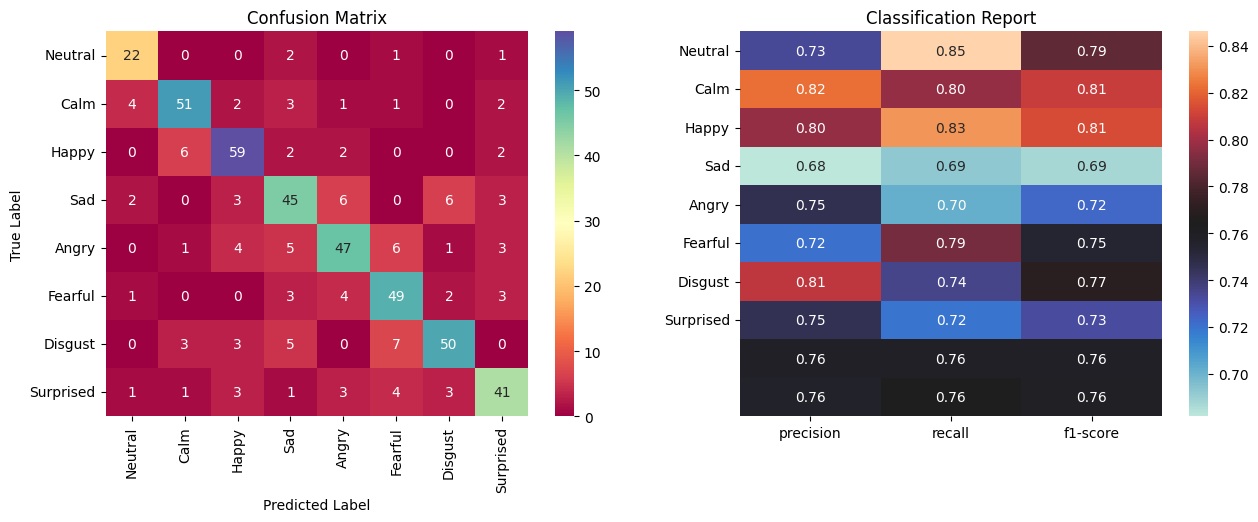

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.733333,0.822581,0.797297,0.681818,0.746032,0.720588,0.806452,0.745455,0.758333,0.756694,0.759642
recall,0.846154,0.796875,0.830986,0.692308,0.701493,0.790323,0.735294,0.719298,0.758333,0.764091,0.758333
f1-score,0.785714,0.809524,0.813793,0.687023,0.723077,0.753846,0.769231,0.732143,0.758333,0.759294,0.758122
support,26.000000,64.000000,71.000000,65.000000,67.000000,62.000000,68.000000,57.000000,0.758333,480.000000,480.000000


In [10]:
mlp = MLPClassifier(alpha=0.05, batch_size=256, epsilon=1e-8, n_iter_no_change=5, learning_rate='adaptive', hidden_layer_sizes=(250, 500), max_iter=500, random_state=42)
mlp.fit(V_train, y_train)

print('Performance of Video Data Alone:')
visualize_results(V_test, y_test, mlp, labels)

#### Here's the performance of the audio data alone:

Performance of Audio Data Alone:
Model accuracy: 0.71875


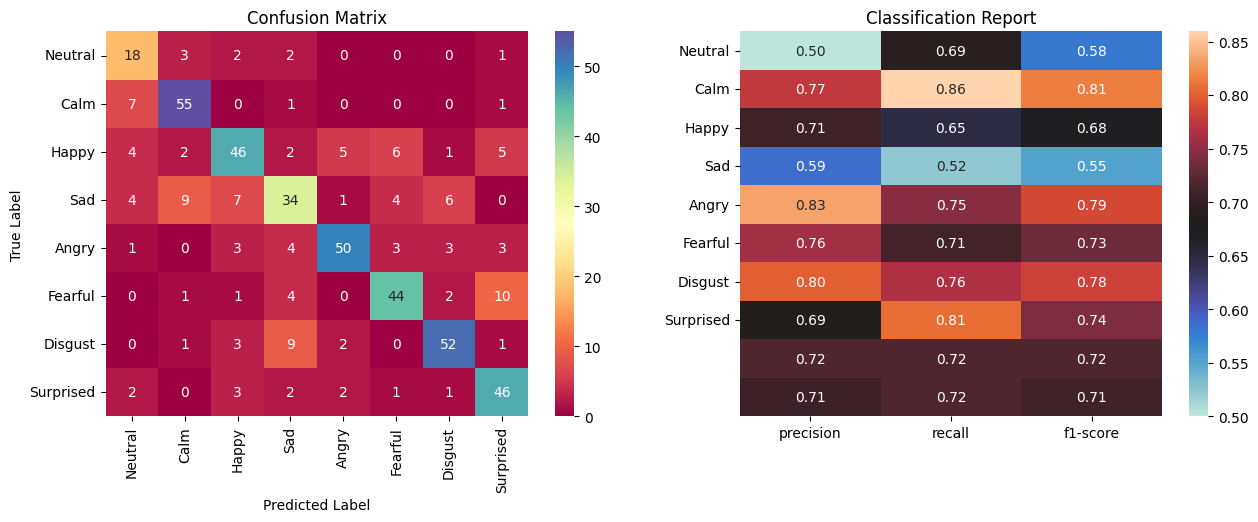

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.500000,0.774648,0.707692,0.586207,0.833333,0.758621,0.800000,0.686567,0.71875,0.705884,0.723603
recall,0.692308,0.859375,0.647887,0.523077,0.746269,0.709677,0.764706,0.807018,0.71875,0.718790,0.718750
f1-score,0.580645,0.814815,0.676471,0.552846,0.787402,0.733333,0.781955,0.741935,0.71875,0.708675,0.718532
support,26.000000,64.000000,71.000000,65.000000,67.000000,62.000000,68.000000,57.000000,0.71875,480.000000,480.000000


In [11]:
mlp = MLPClassifier(alpha=0.05, batch_size=256, epsilon=1e-8, n_iter_no_change=5, learning_rate='adaptive', hidden_layer_sizes=(300, 100), max_iter=500, random_state=42)
mlp.fit(A_train, y_train)

print('Performance of Audio Data Alone:')
visualize_results(A_test, y_test, mlp, labels)

#### Here's the performance of the combined dataset:

In [12]:
X_train = np.concatenate((V_train, A_train), axis=1)
X_test = np.concatenate((V_test, A_test), axis=1)

print(X_train.shape)
print(X_test.shape)

(960, 3228)
(480, 3228)


Performance of Video and Audio Data Together:
Model accuracy: 0.85625


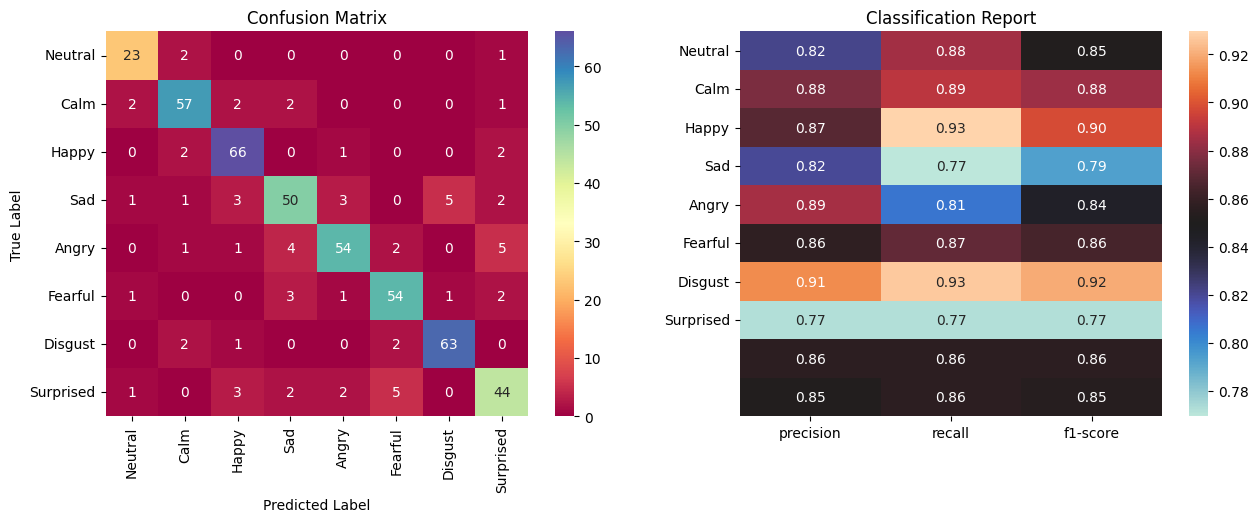

,0,1,2,3,4,5,6,7,accuracy,macro avg,weighted avg
precision,0.821429,0.876923,0.868421,0.819672,0.885246,0.857143,0.913043,0.77193,0.85625,0.851726,0.856163
recall,0.884615,0.890625,0.929577,0.769231,0.805970,0.870968,0.926471,0.77193,0.85625,0.856173,0.856250
f1-score,0.851852,0.883721,0.897959,0.793651,0.843750,0.864000,0.919708,0.77193,0.85625,0.853321,0.855600
support,26.000000,64.000000,71.000000,65.000000,67.000000,62.000000,68.000000,57.00000,0.85625,480.000000,480.000000


In [26]:
mlp = MLPClassifier(alpha=0.07, batch_size=200, epsilon=1e-8, n_iter_no_change=10, learning_rate='adaptive', hidden_layer_sizes=(250, 500, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

print('Performance of Video and Audio Data Together:')
visualize_results(X_test, y_test, mlp, labels)

### References:

[1] Kolda, Tamara G., and Brett W. Bader. "Tensor Decompositions and Applications." *SIAM Review*, vol. 51, no. 3, 2009, pp. 455-500. Society for Industrial and Applied Mathematics. https://doi.org/10.1137/07070111X.
